In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [12]:
df = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


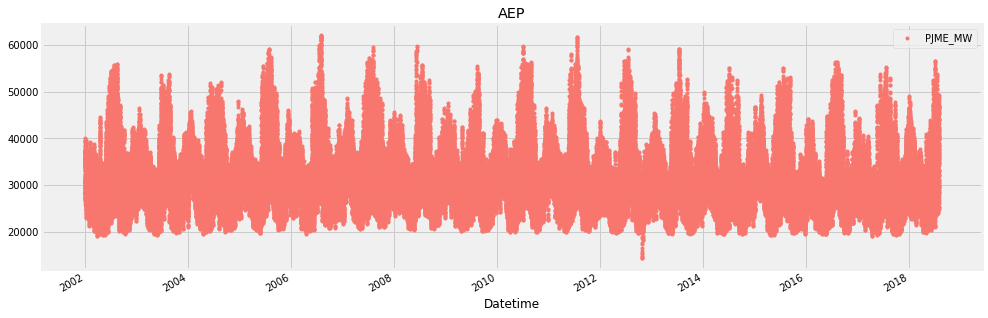

In [13]:
color_pal = ["#F8766D"]
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='AEP')
plt.show()

#EDA

In [14]:
def create_features(df, label=None):
  df = df.copy()
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear

  X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]

  if label:
    y = df[label]
    return X, y

X, y = create_features(df, label = 'PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [15]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


#Plotting the features to see trends

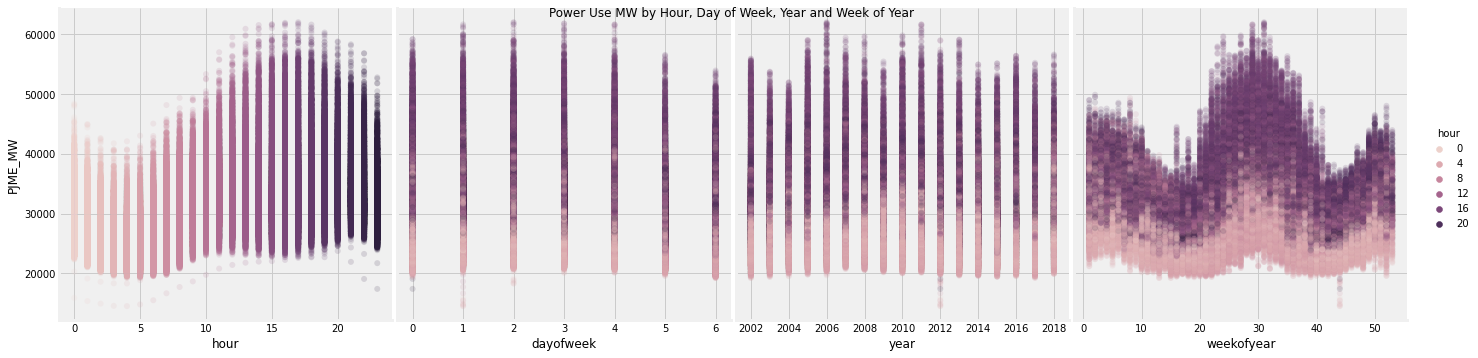

In [20]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour', 'dayofweek', 'year', 'weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0})
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

#Train and Test Split

In [23]:
split_date = '01-Jan-2015'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

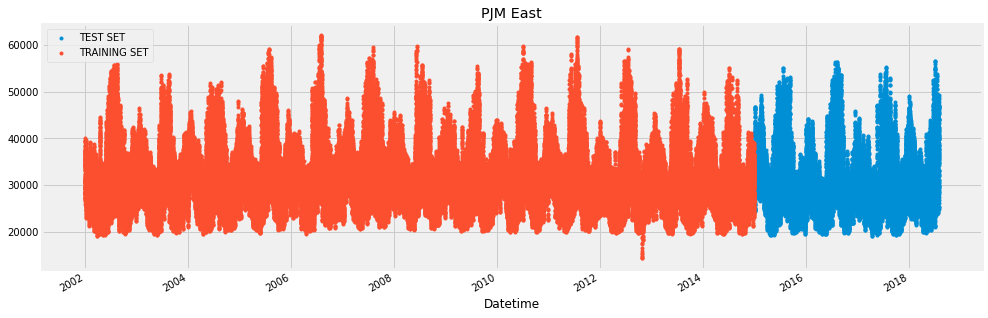

In [26]:
#plot train and test to show where we split the data
df_test.rename(columns={'PJME_MW': 'TEST SET'}).join(df_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

#Simple Prophet Model

In [31]:
#format data for prophet model using ds and y
df_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [33]:
#Setup and train model and fit
model=Prophet()
model.fit(df_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

In [37]:
#Predict on training set with model
df_test_forecast = model.predict(df=df_test.reset_index().rename(columns={'Datetime':'ds'}))

In [38]:
df_test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31190.115784,23984.813777,32773.596874,31190.115784,31190.115784,-2820.067931,-2820.067931,-2820.067931,-4430.324151,...,1281.432109,1281.432109,1281.432109,328.824111,328.824111,328.824111,0.0,0.0,0.0,28370.047853
1,2015-01-01 02:00:00,31190.075956,22663.840526,31395.459570,31190.075956,31190.075956,-4324.359473,-4324.359473,-4324.359473,-5927.199911,...,1272.673300,1272.673300,1272.673300,330.167138,330.167138,330.167138,0.0,0.0,0.0,26865.716483
2,2015-01-01 03:00:00,31190.036128,21529.564153,30415.639759,31190.036128,31190.036128,-5196.010627,-5196.010627,-5196.010627,-6790.271265,...,1262.709009,1262.709009,1262.709009,331.551628,331.551628,331.551628,0.0,0.0,0.0,25994.025500
3,2015-01-01 04:00:00,31189.996300,21089.297052,29995.363100,31189.996300,31189.996300,-5337.553296,-5337.553296,-5337.553296,-6922.193706,...,1251.662803,1251.662803,1251.662803,332.977607,332.977607,332.977607,0.0,0.0,0.0,25852.443003
4,2015-01-01 05:00:00,31189.956472,21830.751609,31022.748697,31189.956472,31189.956472,-4663.215490,-4663.215490,-4663.215490,-6237.331039,...,1239.670450,1239.670450,1239.670450,334.445099,334.445099,334.445099,0.0,0.0,0.0,26526.740982


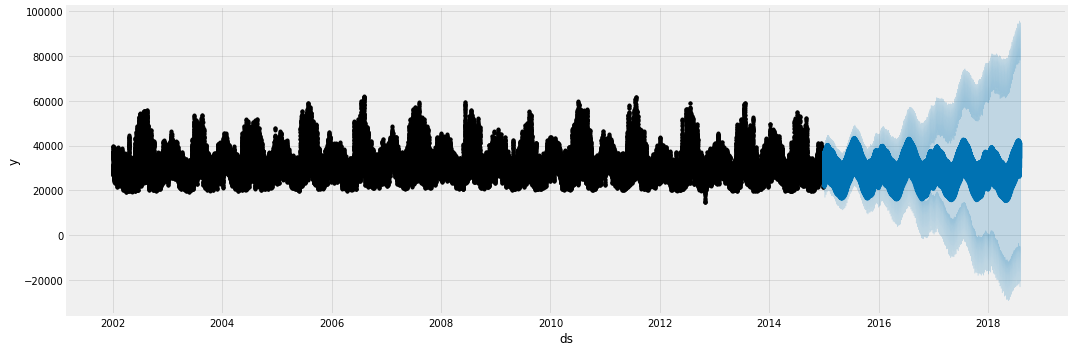

In [39]:
#Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_forecast, ax=ax)
plt.show()

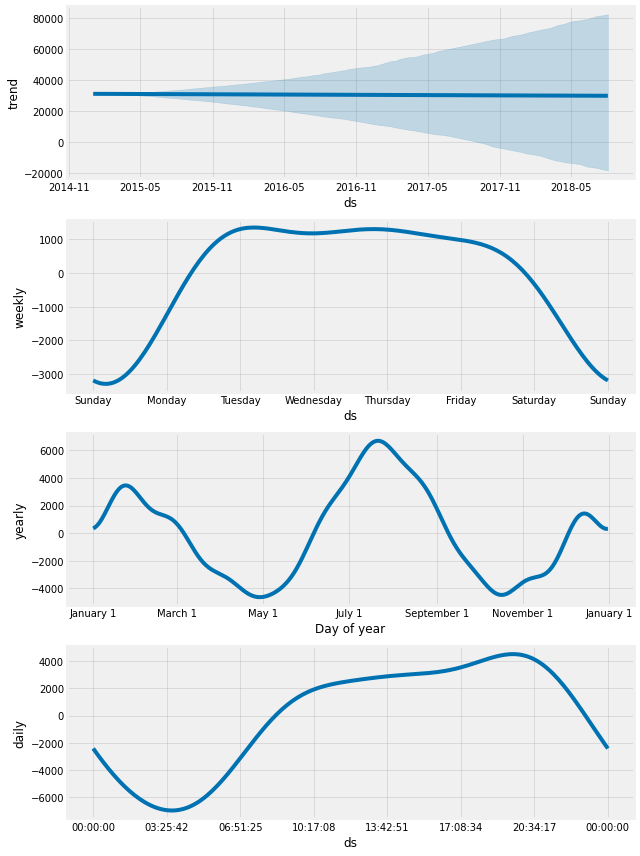

In [40]:
#Plot the components of the model
fig = model.plot_components(df_test_forecast)

#Compare Forecast to Actuals

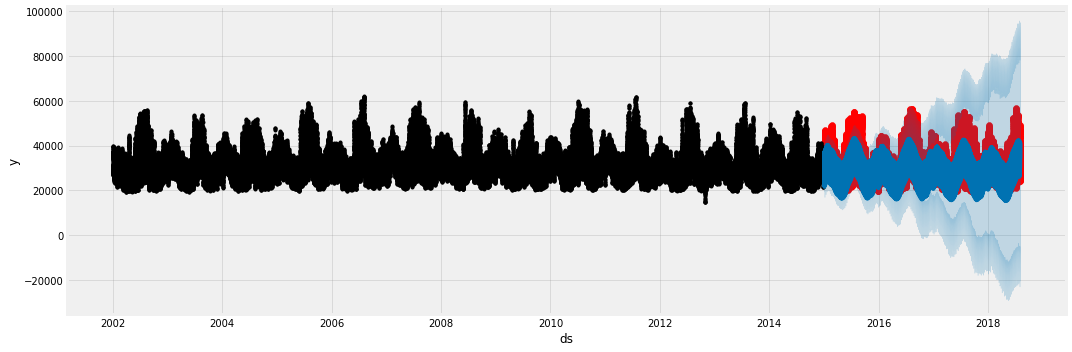

In [42]:
#plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['PJME_MW'], color='red')
fig = model.plot(df_test_forecast, ax=ax)